In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import scripts.utils as utils
plot_kwargs = {'bbox_inches': "tight", 'dpi': 200}

config = utils.load_config("scripts")
tempdir = config['paths']['tempdir']
indir = config['paths']['resultsdir']
outdir = config['paths']['resultsdir']
figdir = config['paths']['figdir']


RZ_IDS = [*gpd.read_file(os.path.join(tempdir, "wrz_buffer.gpkg"))['RZ_ID'].unique()]
INDICATOR = "ep"
SCENARIOS = ["BS", "NF", "FF"]
INDICATORS = ['ep_total', 'ep_mean', 'q50_anomaly_total', 'q75_anomaly_total', 'q90_anomaly_total', 'q50_deficit_total']

In [2]:
event_df = pd.read_csv("/Users/alison/Documents/RAPID/correlation_analysis/data_results/nf/events/wrz_83.csv")
event_df

,RZ_ID,ensemble,event,start,end,severity,duration,backcast,buffer,ep_total,ep_mean,q50_anomaly_total,q75_anomaly_total,q90_anomaly_total,q50_deficit_total
0,83,NF1,1,2021-03-16,2021-03-16,1.1,0 days,3,10.0,-3.013396,-3.013396,3.037791,0.367381,-1.784131,0.000000
1,83,NF1,1,2021-03-16,2021-03-16,1.1,0 days,3,25.0,-9.426161,-3.142054,8.727401,0.716169,-5.738366,0.230746
2,83,NF1,1,2021-03-16,2021-03-16,1.1,0 days,3,50.0,-41.226874,-3.171298,37.438564,2.723226,-25.246427,2.163638
3,83,NF1,1,2021-03-16,2021-03-16,1.1,0 days,3,100.0,-167.716430,-3.288557,140.894135,4.703193,-105.023906,25.295669
4,83,NF1,1,2021-03-16,2021-03-16,1.1,0 days,3,150.0,-390.527658,-3.649791,256.949409,-28.784527,-258.996284,104.968519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64045,83,NF100,1830,2049-12-16,2049-12-16,0.4,0 days,36,50.0,-114.181995,-8.783230,-16.509930,-423.945128,-713.765900,214.045565
64046,83,NF100,1830,2049-12-16,2049-12-16,0.4,0 days,36,100.0,-768.875285,-15.075986,-385.700259,-1984.099884,-3121.089068,1018.208251
64047,83,NF100,1830,2049-12-16,2049-12-16,0.4,0 days,36,150.0,-2155.208838,-20.142139,-1351.292609,-4704.797705,-7090.245599,2474.834229
64048,83,NF100,1830,2049-12-16,2049-12-16,0.4,0 days,36,200.0,-3198.396802,-21.757801,-2093.951141,-6701.103002,-9978.307118,3515.243930


In [3]:
# get correlations for every variable with LoS severity
for RZ_ID in RZ_IDS:
    dfs = []
    for scenario in SCENARIOS:
        datadir = os.path.join(indir, scenario.lower(), "events")
        datapath = os.path.join(datadir, f"wrz_{RZ_ID}.csv")
        if os.path.exists(datapath):
            dfs.append(pd.read_csv(datapath))
    if len(dfs) > 0:
        df_wrz = pd.concat(dfs)

        corr_dfs = []
        for indicator in INDICATORS:
            corrs = {}
            pvals = {}
            for buffer in df_wrz['buffer'].unique():
                df_wrz_buffer = df_wrz[df_wrz['buffer'] == buffer].copy()
                buffer = int(buffer)
                for backcast in df_wrz['backcast'].unique():
                    df_wrz_buffer_backcast = df_wrz_buffer[df_wrz_buffer['backcast'] == backcast].copy()
                    corr, pval = spearmanr(df_wrz_buffer_backcast[indicator], df_wrz_buffer_backcast['severity'])
                    corrs[(buffer, backcast)] = [corr]
                    pvals[(buffer, backcast)] = [pval]

            corrs_df = pd.DataFrame(corrs).transpose().reset_index().rename(columns={'level_0': 'buffer', 'level_1': 'backcast', 0: f'{indicator}_r'})
            pvals_df = pd.DataFrame(pvals).transpose().reset_index().rename(columns={'level_0': 'buffer', 'level_1': 'backcast', 0: f'{indicator}_p'})
            corrs_df[f'{indicator}_p'] = pvals_df[f'{indicator}_p']
            corrs_df = corrs_df.set_index(['buffer', 'backcast'])
            corr_dfs.append(corrs_df)

        corrs_df = pd.concat(corr_dfs, axis=1).reset_index()
        corrs_df.to_csv(os.path.join(outdir, 'correlations', f'wrz_{RZ_ID}.csv'), index=False)
    else:
        print(f"No dataframes found for WRZ {RZ_ID}")

No dataframes found for WRZ 69
No dataframes found for WRZ 91
No dataframes found for WRZ 101


In [42]:
all_df

,RZ_ID,ensemble,event,start,end,severity,duration,backcast,buffer,ep_total,ep_mean,q50_anomaly_total,q75_anomaly_total,q90_anomaly_total,q50_deficit_total
0,1,BS1,1.0,1975-02-16,1975-05-16,97.0,89 days,3.0,25.0,-0.819349,-0.204837,-0.014037,-11.022369,-19.284806,3.532844
1,1,BS1,1.0,1975-02-16,1975-05-16,97.0,89 days,3.0,50.0,-4.378279,-0.364857,-1.962342,-34.987337,-59.774648,12.687874
2,1,BS1,1.0,1975-02-16,1975-05-16,97.0,89 days,3.0,100.0,-10.591623,-0.441318,-5.759748,-71.809739,-121.384362,28.754828
3,1,BS1,1.0,1975-02-16,1975-05-16,97.0,89 days,3.0,150.0,-12.362180,-0.494487,-7.328977,-76.131051,-127.771283,30.940120
4,1,BS1,1.0,1975-02-16,1975-05-16,97.0,89 days,3.0,200.0,-12.362180,-0.494487,-7.328977,-76.131051,-127.771283,30.940120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25981,1,FF100,1107.0,2078-05-16,2078-06-16,30.0,31 days,36.0,50.0,144.105311,12.008776,-167.049795,-519.011042,-793.756517,346.264035
25982,1,FF100,1107.0,2078-05-16,2078-06-16,30.0,31 days,36.0,100.0,243.394791,10.141450,-378.915423,-1082.837915,-1632.328865,720.958423
25983,1,FF100,1107.0,2078-05-16,2078-06-16,30.0,31 days,36.0,150.0,229.540081,9.181603,-418.699724,-1151.952321,-1724.338727,765.993398
25984,1,FF100,1107.0,2078-05-16,2078-06-16,30.0,31 days,36.0,200.0,229.540081,9.181603,-418.699724,-1151.952321,-1724.338727,765.993398


30


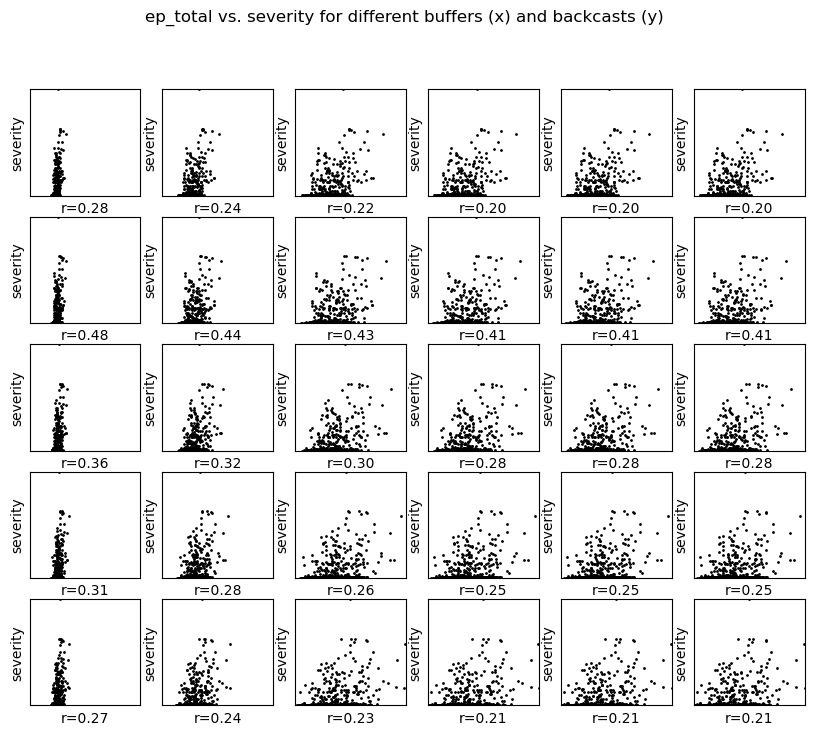

In [53]:
all_df = pd.concat(dfs)
indicator = 'ep_total'
xmin = all_df[indicator].min()
xmax = all_df[indicator].max()
ymax = all_df['severity'].max()

backcasts = all_df['backcast'].unique()
buffers = all_df['buffer'].unique()
print(len(backcasts) * len(buffers))
fig, axs = plt.subplots(len(backcasts), len(buffers), figsize=(10, 8))
for i, backcast in enumerate(backcasts):
    for j, buffer in enumerate(buffers):
        df_sub = all_df[all_df['buffer'] == buffer].copy()
        df_sub = df_sub[df_sub['backcast'] == backcast].copy()
        
        axs[i, j].scatter(df_sub[indicator], df_sub['severity'], s=1, color='k')
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_xlabel(f"r={spearmanr(df_sub[indicator], df_sub['severity'])[0]:.2f}")
        axs[i, j].set_xlim([xmin, xmax])
        axs[i, j].set_ylim([0, ymax])
        axs[i, j].set_ylabel('severity')

fig.suptitle(f"{indicator} vs. severity for different buffers (x) and backcasts (y)");
fig.savefig(os.path.join(figdir, 'correlations', f'scatterplot_{indicator}.png'), **plot_kwargs)

In [5]:
def plot_heatmap(RZ_ID, indicator, outdir):
    corrs_df_wrz = pd.read_csv(os.path.join(outdir, 'correlations', f'wrz_{RZ_ID}.csv'))
    corrs_df_wrz_pivoted = corrs_df_wrz.pivot_table(values=f'{indicator}_r', index='buffer', columns='backcast').transpose()
    pvals_df_wrz_pivoted = corrs_df_wrz.pivot_table(values=f'{indicator}_p', index='buffer', columns='backcast').transpose()
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    im = ax.imshow(corrs_df_wrz_pivoted, cmap='Spectral_r', vmin=-1, vmax=1)
    
    for y in range(corrs_df_wrz_pivoted.shape[0]):
        for x in range(corrs_df_wrz_pivoted.shape[1]):
            ax.text(x, y, '%.2f' % pvals_df_wrz_pivoted.iloc[y, x],
             horizontalalignment='center',
             verticalalignment='center',
          )
            
    ax.set_xticks(range(len(corrs_df_wrz_pivoted.columns)), corrs_df_wrz_pivoted.columns)
    ax.set_yticks(range(len(corrs_df_wrz_pivoted)), corrs_df_wrz_pivoted.index)
    ax.set_ylabel('Backcast (months)')
    ax.set_xlabel('Buffer radius (km)')
    ax.set_title(f"{indicator.replace('_', ' ').capitalize()} vs. Severity")
    ax.invert_yaxis()
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Spearman correlation')
    
    fig.suptitle(f"WRZ {RZ_ID}")
    return fig


for RZ_ID in RZ_IDS:
    for indicator in INDICATORS:
        fig = plot_heatmap(1, indicator, outdir)
        if not os.path.exists(os.path.join(figdir, 'correlations', f"{RZ_ID}")):
            os.makedirs(os.path.join(figdir, 'correlations', f"{RZ_ID}"))
        fig.savefig(os.path.join(figdir, 'correlations', f"{RZ_ID}", f"{indicator}.png"), **plot_kwargs)
        plt.close()

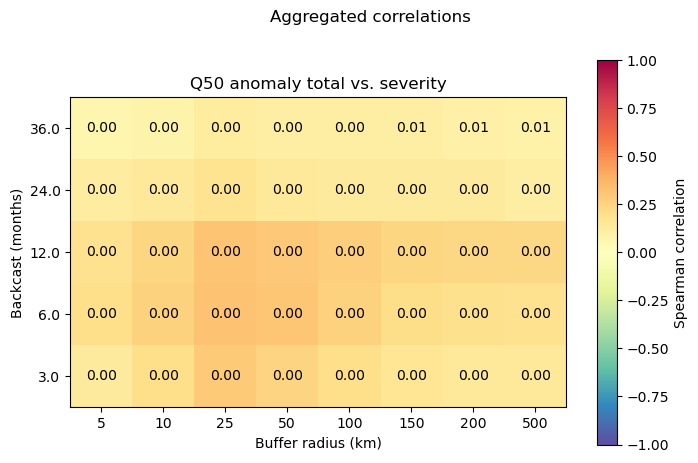

In [6]:
def plot_heatmap2(corrs_df_wrz, indicator):
    corrs_df_wrz_pivoted = corrs_df_wrz.pivot_table(values=f'{indicator}_r', index='buffer', columns='backcast').transpose()
    pvals_df_wrz_pivoted = corrs_df_wrz.pivot_table(values=f'{indicator}_p', index='buffer', columns='backcast').transpose()
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    im = ax.imshow(corrs_df_wrz_pivoted, cmap='Spectral_r', vmin=-1, vmax=1)
    
    for y in range(corrs_df_wrz_pivoted.shape[0]):
        for x in range(corrs_df_wrz_pivoted.shape[1]):
            ax.text(x, y, '%.2f' % pvals_df_wrz_pivoted.iloc[y, x],
             horizontalalignment='center',
             verticalalignment='center',
          )
            
    ax.set_xticks(range(len(corrs_df_wrz_pivoted.columns)), corrs_df_wrz_pivoted.columns)
    ax.set_yticks(range(len(corrs_df_wrz_pivoted)), corrs_df_wrz_pivoted.index)
    ax.set_ylabel('Backcast (months)')
    ax.set_xlabel('Buffer radius (km)')
    ax.set_title(f"{indicator.replace('_', ' ').capitalize()} vs. severity")
    ax.invert_yaxis()
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Spearman correlation')
    
    fig.suptitle(f"Aggregated correlations")
    return fig


import glob
dfs = []
all_corr_csvs = glob.glob(os.path.join(outdir, 'correlations', f'wrz_*.csv'))

for csv in all_corr_csvs:
    dfs.append(pd.read_csv(csv))

    
all_corr_dfs = pd.concat(dfs, axis=0)

# get statistics
mean_corrs = all_corr_dfs.groupby(['buffer', 'backcast']).mean().reset_index()
median_corrs = all_corr_dfs.groupby(['buffer', 'backcast']).median().reset_index()


fig = plot_heatmap2(median_corrs, 'q50_anomaly_total')

Text(0.5, 1.0, 'WRZ 1, backcast 36.0, buffer 500')

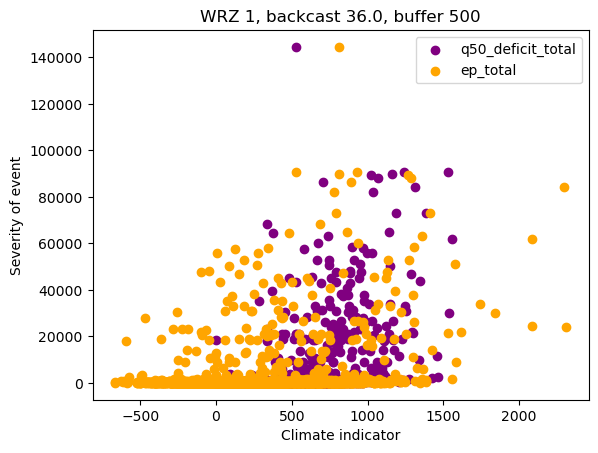

In [7]:
RZ_ID = 1
indicator = 'q50_deficit_total'
dfs = []
for scenario in SCENARIOS:
    datadir = os.path.join(indir, scenario.lower(), "events")
    datapath = os.path.join(datadir, f"wrz_{RZ_ID}.csv")
    if os.path.exists(datapath):
        dfs.append(pd.read_csv(datapath))
if len(dfs) > 0:
    df_wrz = pd.concat(dfs)
    

for buffer in df_wrz['buffer'].unique():
    df_wrz_buffer = df_wrz[df_wrz['buffer'] == buffer].copy()
    buffer = int(buffer)
    for backcast in df_wrz['backcast'].unique():
        df_wrz_buffer_backcast = df_wrz_buffer[df_wrz_buffer['backcast'] == backcast].copy()
        

fig, ax = plt.subplots(1, 1)
ax.scatter(df_wrz_buffer_backcast[indicator], df_wrz_buffer_backcast['severity'], color='purple', label=indicator)

indicator = 'ep_total'
ax.scatter(df_wrz_buffer_backcast[indicator], df_wrz_buffer_backcast['severity'], color='orange', label=indicator)

ax.legend()
ax.set_ylabel('Severity of event')
ax.set_xlabel('Climate indicator')
ax.set_title(f"WRZ {RZ_ID}, backcast {backcast}, buffer {buffer}")

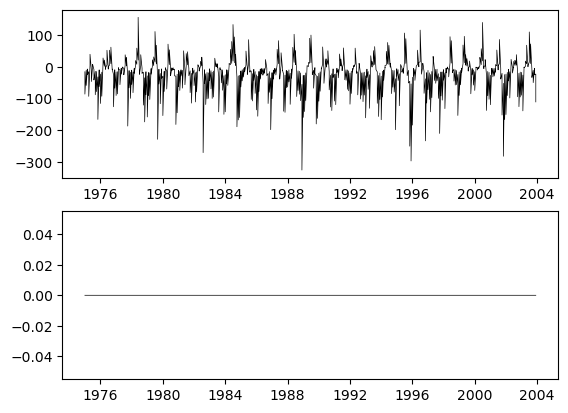

In [8]:
# timeseries
def get_cis(df):
    n = len(df)
    df['mean'] = df.mean(axis=1)
    df['std'] = df.std(axis=1)
    df['upper'] = df['mean'] + 1.96 * df['std'] / np.sqrt(n)
    df['lower'] = df['mean'] - 1.96 * df['std'] / np.sqrt(n)
    return df[['mean', 'std', 'lower', 'upper']]
    
    
def compare_timeseries(RZ_ID, scenario, indicator):
    datadir = os.path.join(indir, scenario.lower(), "full_timeseries", f"wrz_{RZ_ID}")
    files = glob.glob(os.path.join(datadir, "*.parquet"))

    los_ensembles = []
    indicator_ensembles = []

    for file in files:
        df = pd.read_parquet(files[0])
        los_ensembles.append(df['LoS'])
        indicator_ensembles.append(df[indicator])

    los = pd.concat(los_ensembles, axis=1)
    indicators = pd.concat(indicator_ensembles, axis=1)
    los = get_cis(los)
    indicators = get_cis(indicators)

    df['Day'] = [1] * len(df)
    df['date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    los[['date', 'buffer']] = df[['date', 'buffer']]
    indicators[['date', 'buffer']] = df[['date', 'buffer']]

    BUFFER = 25
    indicators_buffer = indicators[indicators['buffer'] == BUFFER]
    los_buffer = los[los['buffer'] == BUFFER]

    fig, ax = plt.subplots(2, 1)
    ax[0].plot(indicators['date'], indicators['mean'], color='k', linewidth=.5)
    ax[0].fill_between(indicators['date'], indicators['lower'], indicators['upper'], alpha=.1)
    ax[1].plot(los['date'], los['mean'], color='k', linewidth=.5)
    ax[1].fill_between(los['date'], los['lower'], los['upper'], alpha=.1)
    
    return df
    
RZ_ID = 99
indicator = 'ep_total'
scenario = 'BS'

df  = compare_timeseries(RZ_ID, scenario, indicator)

In [9]:
df[['date', 'ep_total', 'LoS']]

,date,ep_total,LoS
0,1975-01-01,-15.618546,0.0
1,1975-01-01,-47.777880,0.0
2,1975-01-01,-70.072708,0.0
3,1975-01-01,-83.092572,0.0
4,1975-01-01,-85.841646,0.0
...,...,...,...
2083,2003-12-01,-60.449663,0.0
2084,2003-12-01,-88.070651,0.0
2085,2003-12-01,-104.976154,0.0
2086,2003-12-01,-110.295899,0.0


## Old stuff

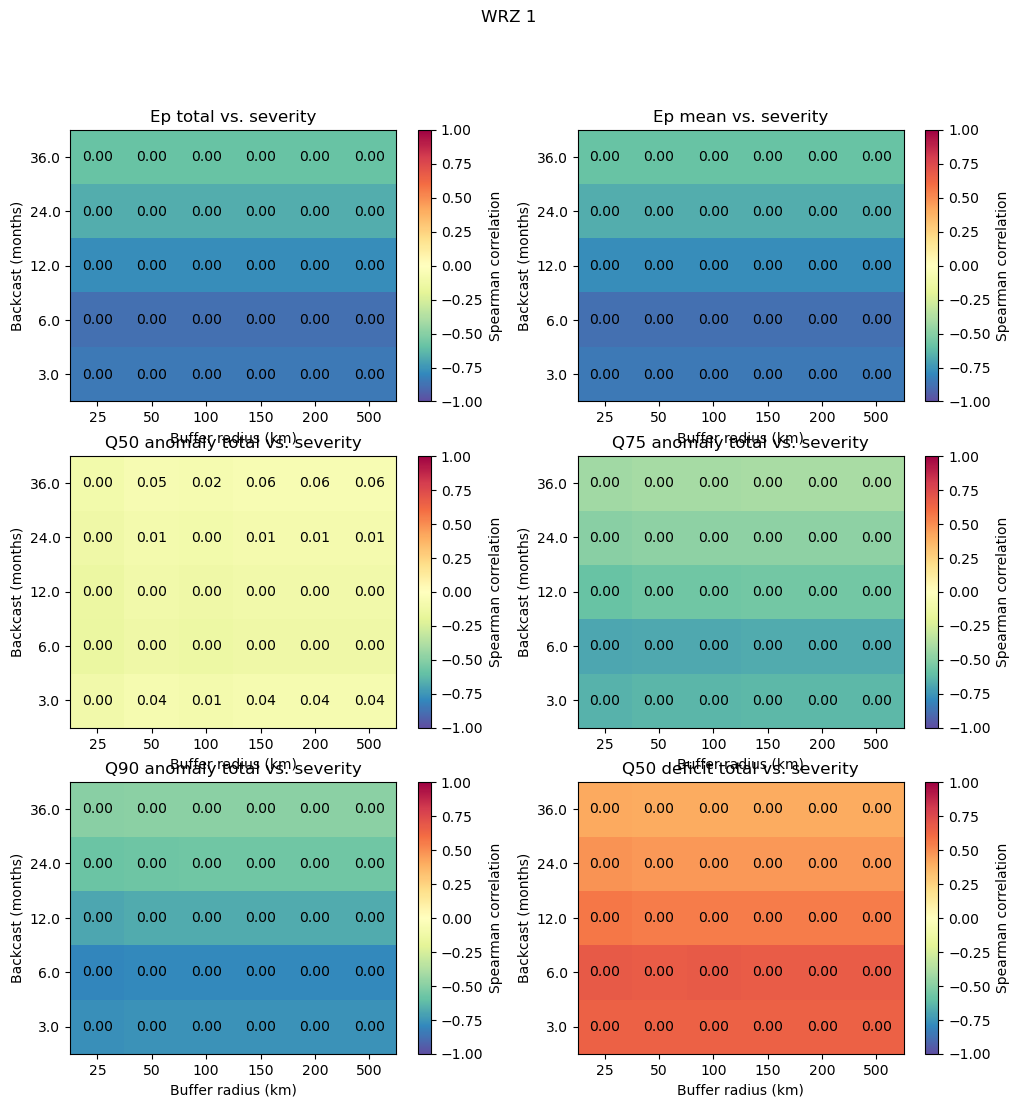

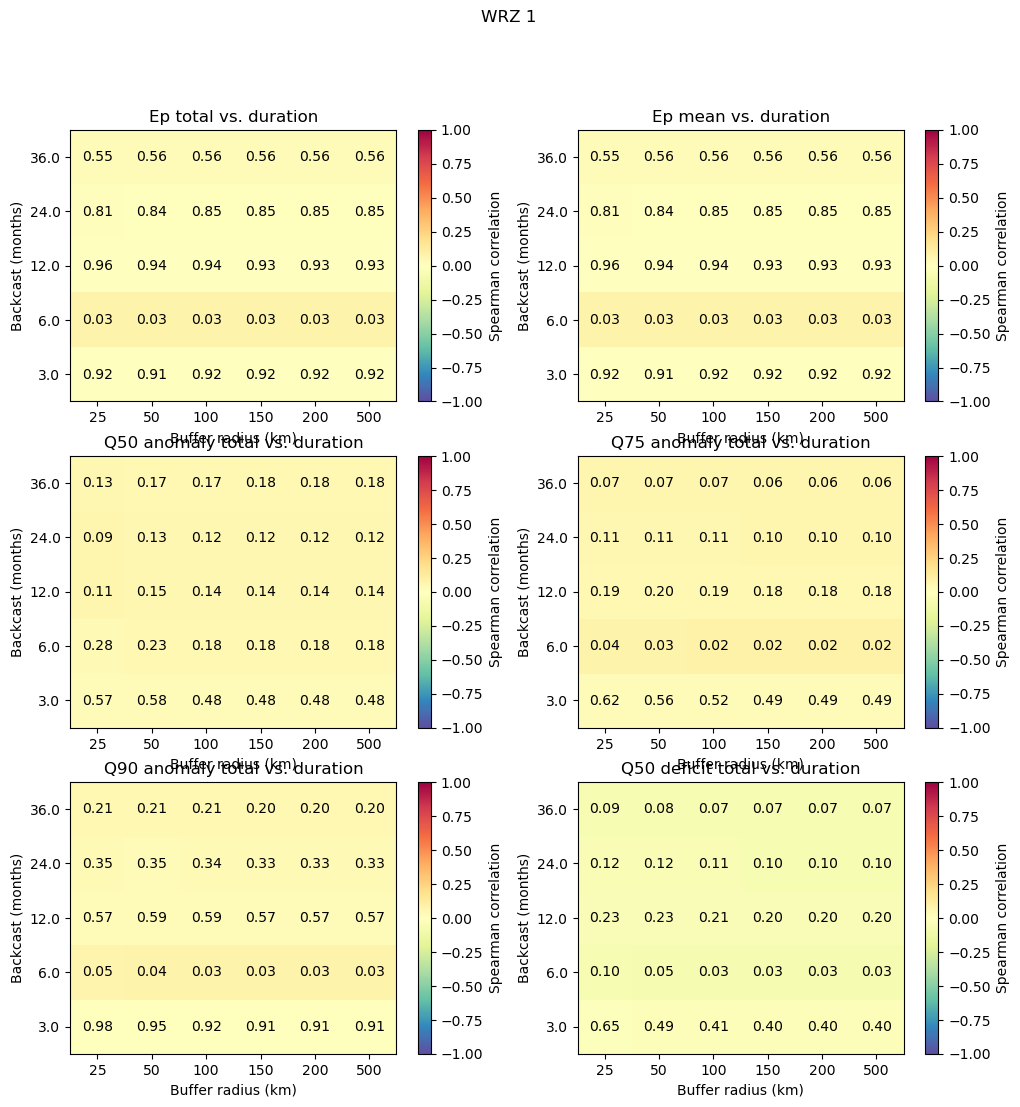

In [82]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
for indicator, ax in zip(indicators, axs.ravel()):
    corrs = {}
    pvals = {}
    for buffer in df_wrz['buffer'].unique():
        df_wrz_buffer = df_wrz[df_wrz['buffer'] == buffer].copy()
        buffer = int(buffer)
        for backcast in df_wrz['backcast'].unique():
            df_wrz_buffer_backcast = df_wrz_buffer[df_wrz_buffer['backcast'] == backcast].copy()
            corr, pval = spearmanr(df_wrz_buffer_backcast[indicator], df_wrz_buffer_backcast['severity'])
            corrs[(buffer, backcast)] = [corr]
            pvals[(buffer, backcast)] = [pval]
    
    corrs_df_wrz = pd.DataFrame(corrs).transpose().reset_index().rename(columns={'level_0': 'buffer', 'level_1': 'backcast', 0: 'corr'})
    corrs_df_wrz_pivoted = corrs_df_wrz.pivot_table(values='corr', index='buffer', columns='backcast').transpose()
    im = ax.imshow(corrs_df_wrz_pivoted, cmap='Spectral_r', vmin=-1, vmax=1)
    
    # add p-values
    pvals_df = pd.DataFrame(pvals).transpose().reset_index().rename(columns={'level_0': 'buffer', 'level_1': 'backcast', 0: 'pval'})
    pvals_df_wrz_pivoted = pvals_df.pivot_table(values='pval', index='buffer', columns='backcast').transpose()
    for y in range(corrs_df_wrz_pivoted.shape[0]):
        for x in range(corrs_df_wrz_pivoted.shape[1]):
            ax.text(x, y, '%.2f' % pvals_df_wrz_pivoted.iloc[y, x],
             horizontalalignment='center',
             verticalalignment='center',
          )
            
    ax.set_xticks(range(len(corrs_df_wrz_pivoted.columns)), corrs_df_wrz_pivoted.columns)
    ax.set_yticks(range(len(corrs_df_wrz_pivoted)), corrs_df_wrz_pivoted.index)
    ax.set_ylabel('Backcast (months)')
    ax.set_xlabel('Buffer radius (km)')
    ax.set_title(f"{indicator.replace('_', ' ').capitalize()} vs. severity")
    ax.invert_yaxis()
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Spearman correlation')

fig.suptitle(f"WRZ {RZ_ID}")
fig.savefig(os.path.join(figdir, "correlations", f"rainfall_v_severity_corr_wrz{RZ_ID}.png"), **plot_kwargs)
plt.show()


# versus duration
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
for indicator, ax in zip(indicators, axs.ravel()):
    corrs = {}
    pvals = {}
    for buffer in df_wrz['buffer'].unique():
        df_wrz_buffer = df_wrz[df_wrz['buffer'] == buffer].copy()
        buffer = int(buffer)
        for backcast in df_wrz['backcast'].unique():
            df_wrz_buffer_backcast = df_wrz_buffer[df_wrz_buffer['backcast'] == backcast].copy()
            corr, pval = spearmanr(df_wrz_buffer_backcast[indicator], df_wrz_buffer_backcast['duration'])
            corrs[(buffer, backcast)] = [corr]
            pvals[(buffer, backcast)] = [pval]

    corrs_df_wrz = pd.DataFrame(corrs).transpose().reset_index().rename(columns={'level_0': 'buffer', 'level_1': 'backcast', 0: 'corr'})
    corrs_df_wrz_pivoted = corrs_df_wrz.pivot_table(values='corr', index='buffer', columns='backcast').transpose()
    im = ax.imshow(corrs_df_wrz_pivoted, cmap='Spectral_r', vmin=-1, vmax=1)
    
    # add p-values
    pvals_df = pd.DataFrame(pvals).transpose().reset_index().rename(columns={'level_0': 'buffer', 'level_1': 'backcast', 0: 'pval'})
    pvals_df_wrz_pivoted = pvals_df.pivot_table(values='pval', index='buffer', columns='backcast').transpose()
    for y in range(corrs_df_wrz_pivoted.shape[0]):
        for x in range(corrs_df_wrz_pivoted.shape[1]):
            ax.text(x, y, '%.2f' % pvals_df_wrz_pivoted.iloc[y, x],
             horizontalalignment='center',
             verticalalignment='center',
          )

    ax.set_xticks(range(len(corrs_df_wrz_pivoted.columns)), corrs_df_wrz_pivoted.columns)
    ax.set_yticks(range(len(corrs_df_wrz_pivoted)), corrs_df_wrz_pivoted.index)
    ax.set_ylabel('Backcast (months)')
    ax.set_xlabel('Buffer radius (km)')
    ax.set_title(f"{indicator.replace('_', ' ').capitalize()} vs. duration")
    ax.invert_yaxis()
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Spearman correlation')

fig.suptitle(f"WRZ {RZ_ID}")
fig.savefig(os.path.join(figdir, "correlations", f"rainfall_v_duration_corr_wrz{RZ_ID}.png"), **plot_kwargs)
plt.show()

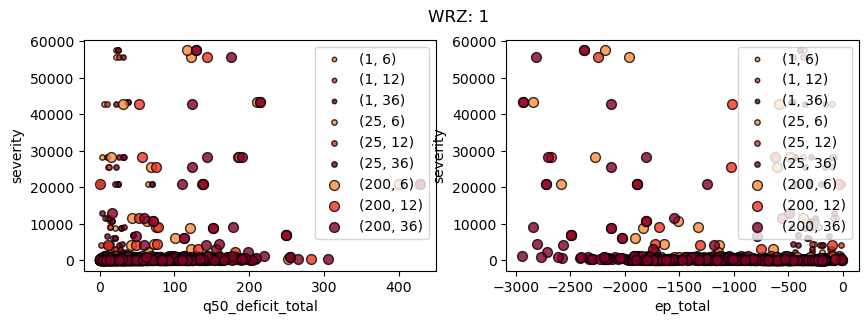

In [69]:
import matplotlib
kwargs = {'alpha': 0.8, 'edgecolor': 'k'}


cmap = matplotlib.colormaps.get_cmap('YlOrRd')
norm = matplotlib.colors.LogNorm(vmin=1, vmax=37)

def scale(buffer):
    return buffer / 5 + 10

fig, axs = plt.subplots(1, 2, figsize=(10, 3))


ax = axs[0]
for buffer in [1, 25, 200]:
    for backcast in [6, 12, 36]:     
        df_wrz_buffer = df_wrz[df_wrz['buffer'] == buffer].copy()
        df_wrz_buffer_backcast = df_wrz_buffer[df_wrz_buffer['backcast'] == backcast].copy()
        ax.scatter(df_wrz_buffer_backcast['q50_deficit_total'], df_wrz_buffer_backcast['severity'], color=cmap(norm(backcast)), label=f'({buffer}, {backcast})', s=scale(buffer), **kwargs)
        ax.set_ylabel('severity')
        ax.set_xlabel('q50_deficit_total')
        ax.legend(loc='upper right')
        
        
ax = axs[1]
for buffer in [1, 25, 200]:
    for backcast in [6, 12, 36]:     
        df_wrz_buffer = df_wrz[df_wrz['buffer'] == buffer].copy()
        df_wrz_buffer_backcast = df_wrz_buffer[df_wrz_buffer['backcast'] == backcast].copy()
        ax.scatter(df_wrz_buffer_backcast[f'{INDICATOR}_total'], df_wrz_buffer_backcast['severity'], color=cmap(norm(backcast)), label=f'({buffer}, {backcast})', s=scale(buffer), **kwargs)
        ax.set_ylabel('severity')
        ax.set_xlabel(f'{INDICATOR}_total')
        ax.legend(loc='upper right')

fig.suptitle(f"WRZ: {RZ_ID}")
fig.savefig(os.path.join(figdir, "correlations", f"scatterplot_wrz{RZ_ID}.png"), **plot_kwargs)

In [ ]:
for RZ_ID in RZ_IDS:
    df_wrz = df[df["RZ_ID"] == RZ_ID]
    indicators = df_wrz.columns[8:]
    
    fig, axs = plt.subplots(3, 2, figsize=(12, 10))
    for indicator, ax in zip(indicators, axs.ravel()):
        corrs = {}
        for buffer in df_wrz['buffer'].unique():
            df_wrz_buffer = df_wrz[df_wrz['buffer'] == buffer].copy()
            buffer = int(buffer)
            for backcast in df_wrz['backcast'].unique():
                df_wrz_buffer_backcast = df_wrz_buffer[df_wrz_buffer['backcast'] == backcast].copy()
                corrs[(buffer, backcast)] = [df_wrz_buffer_backcast[indicator].corr(df_wrz_buffer_backcast['severity'], method='spearman')]

        corrs_df_wrz = pd.DataFrame(corrs).transpose().reset_index().rename(columns={'level_0': 'buffer', 'level_1': 'backcast', 0: 'corr'})
        corrs_df_wrz_pivoted = corrs_df_wrz.pivot_table(values='corr', index='buffer', columns='backcast').transpose()
        corrs_df_wrz_pivoted

        im = ax.imshow(corrs_df_wrz_pivoted, cmap='Spectral_r', vmin=-1, vmax=1)
        ax.set_xticks(range(len(corrs_df_wrz_pivoted.columns)), corrs_df_wrz_pivoted.columns)
        ax.set_yticks(range(len(corrs_df_wrz_pivoted)), corrs_df_wrz_pivoted.index)
        ax.set_ylabel('Backcast (months)')
        ax.set_xlabel('Buffer radius (km)')
        ax.set_title(f"{indicator.replace('_', ' ').capitalize()} vs. severity")
        ax.invert_yaxis()
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Spearman correlation')

    fig.suptitle(f"WRZ {RZ_ID}")
    fig.savefig(os.path.join(datadir, "figures", "correlations", f"rainfall_v_severity_corr_wrz{RZ_ID}.png"), **plot_kwargs)
    plt.show()
    
    
    fig, axs = plt.subplots(3, 2, figsize=(12, 10))
    for indicator, ax in zip(indicators, axs.ravel()):
        corrs = {}
        for buffer in df_wrz['buffer'].unique():
            df_wrz_buffer = df_wrz[df_wrz['buffer'] == buffer].copy()
            buffer = int(buffer)
            for backcast in df_wrz['backcast'].unique():
                df_wrz_buffer_backcast = df_wrz_buffer[df_wrz_buffer['backcast'] == backcast].copy()
                corrs[(buffer, backcast)] = [df_wrz_buffer_backcast[indicator].corr(df_wrz_buffer_backcast['duration'], method='spearman')]

        corrs_df_wrz = pd.DataFrame(corrs).transpose().reset_index().rename(columns={'level_0': 'buffer', 'level_1': 'backcast', 0: 'corr'})
        corrs_df_wrz_pivoted = corrs_df_wrz.pivot_table(values='corr', index='buffer', columns='backcast').transpose()
        corrs_df_wrz_pivoted

        im = ax.imshow(corrs_df_wrz_pivoted, cmap='Spectral_r', vmin=-1, vmax=1)
        ax.set_xticks(range(len(corrs_df_wrz_pivoted.columns)), corrs_df_wrz_pivoted.columns)
        ax.set_yticks(range(len(corrs_df_wrz_pivoted)), corrs_df_wrz_pivoted.index)
        ax.set_ylabel('Backcast (months)')
        ax.set_xlabel('Buffer radius (km)')
        ax.set_title(f"{indicator.replace('_', ' ').capitalize()} vs. duration")
        ax.invert_yaxis()
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('Spearman correlation')

    fig.suptitle(f"WRZ {RZ_ID}")
    fig.savefig(os.path.join(datadir, "figures", "correlations", f"rainfall_v_duration_corr_wrz{RZ_ID}.png"), **plot_kwargs)
    plt.show()